## Reservoir Computer


In [19]:
##### RESERVOIR SYSTEM #####

def create_system(output_dim, reservoir_dim, spectral_radius, edge_creation_prob, seed, graph_type, random_edge_probability):

  reservoir = np.zeros(reservoir_dim)
  reservoir_input = (np.random.rand(reservoir_dim, output_dim) - .5) * edge_creation_prob

  if graph_type == 'default':
    if not random_edge_probability:
      graph = nx.gnp_random_graph(reservoir_dim, edge_creation_prob, seed)
    else:

      graph = nx.Graph()
      for i in range(reservoir_dim):
        graph.add_node(i)

      i = 0
      num_edges_prob = comb(reservoir_dim, 2) * 0.5
      while True:
        if i >= num_edges_prob:
          break
        node1 = np.random.randint(0, reservoir_dim)
        node2 = np.random.randint(0, reservoir_dim)
        while node2 == node1:
          node2 = np.random.randint(0, reservoir_dim)
        if node1 not in graph[node2]:
          probability = np.random.uniform(0, 1)
          val = np.random.randint(0, 1000000000)
          if val < probability * 1000000000:
            graph.add_edge(node1, node2)
            graph.add_edge(node2, node1)
            i += 1

  elif graph_type == 'complete':
    graph = nx.complete_graph(reservoir_dim)

  elif graph_type == 'tree':
    graph = nx.random_powerlaw_tree(reservoir_dim, seed=seed, tries=reservoir_dim* 1000)

  graph = nx.to_numpy_array(graph)

  rand_mat = 2 * (np.random.rand(reservoir_dim, reservoir_dim) - 0.5)
  scale_mat = graph * rand_mat
  ev = np.linalg.eig(scale_mat)[0]
  max_ev = np.max(ev)
  rescale_mat = scale_mat/np.absolute(max_ev) * spectral_radius

  return rescale_mat, reservoir, reservoir_input

def fit(data, output_dim, reservoir_dim, reservoir, adj, reservoir_input):

  reservoir_output = np.zeros((output_dim, reservoir_dim))
  state_matrix = np.zeros((reservoir_dim, data.shape[0]))

  for time_step in range(data.shape[0]):
      np.put(state_matrix[:, time_step], range(len(state_matrix)), reservoir)
      x = np.dot(adj, reservoir) + np.dot(reservoir_input, data[time_step])

      reservoir = np.tanh(x)

  transposed_matrix = np.transpose(state_matrix)
  identity_matrix = 0.0001 * np.identity(state_matrix.shape[0])
  inverse_part = np.linalg.solve(np.dot(state_matrix, transposed_matrix) + identity_matrix, np.eye(state_matrix.shape[0]))
  reservoir_output = np.dot(np.dot(data.T, transposed_matrix), inverse_part)

  return reservoir, reservoir_output

def forecast(future_data, output_dim, reservoir, adj, reservoir_input, reservoir_output):
  pred = np.zeros((future_data, output_dim))
  for time_step in range(future_data):
      pred[time_step] = np.dot(reservoir_output, reservoir)
      x = np.dot(adj, reservoir) + np.dot(reservoir_input, pred[time_step])
      reservoir = np.tanh(x)
  return pred

def create_fit_forecast(output_dim, reservoir_dim, scaler, edge_creation_prob, seed, graph_type="default",
                        random_edge_probability=False, data=None, future_data=None):

  adj, reservoir, reservoir_input = create_system(output_dim, reservoir_dim, scaler, edge_creation_prob, seed, graph_type, random_edge_probability)

  if data is None: return adj, reservoir, reservoir_input
  else: reservoir, reservoir_output = fit(data, output_dim, reservoir_dim, reservoir, adj, reservoir_input)

  if future_data is None: return adj, reservoir, reservoir_input, reservoir_output
  else: preds = forecast(future_data, output_dim, reservoir, adj, reservoir_input, reservoir_output)

  return preds

##### OTHER METHODS #####

def average_forecast_horizon(preds, actual):
  s = np.std(actual)
  x, y, z = 0, 0, 0
  for i, vals in enumerate(preds):
    x += (preds[i][0] - actual[i][0]) < s
    y += (preds[i][1] - actual[i][1]) < s
    z += (preds[i][2] - actual[i][2]) < s
  return x/len(preds), y/len(preds), z/len(preds)

def getAccuracy(predicted_data, testing_data):
  return average_forecast_horizon(predicted_data, testing_data)

def makeAndSaveGraph(test, pred, title=None):
  fig, ax = plt.subplots(3, 1, figsize=(9, 9))
  t = [i for i in range(trainLength, n_timesteps)]
  temp = ['X', 'Y', 'Z']
  color_table = ['red', 'green', 'blue']
  if title:
    ax[0].set_title(title+'\n')
  for i in range(3):
    if i == 0:
      new_title = title + '\n' + "Predicted Lorenz " + temp[i] + " Data and Actual Lorenz " + temp[i] + " Data"
    else:
      new_title = "Predicted Lorenz " + temp[i] + " Data and Actual Lorenz " + temp[i] + " Data"
    ax[i].set_title(new_title)
    ax[i].set_xlabel("timestep")
    ax[i].plot(t, test[:, i], label=temp[i], color=color_table[i])
    ax[i].plot(t, pred[:, i], label=temp[i]+"_pred")
    ax[i].legend()

  fig.tight_layout()

  plt.show(title + ".jpg")

## Initial Point Classification for rho = 22

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Define the Lorenz system
def lorenz(t, state, sigma=10, beta=8/3, rho=22):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

In [3]:
# Parameters
rho = 22  # Given rho value
sigma = 10
beta = 8/3
t_end = 50
t_span = (0, t_end)  # Time span for evolution
t_eval = np.linspace(*t_span, t_end*100)  # Time points

In [69]:
y_min, y_max, y_step = -20, 20, 50
z_min, z_max, z_step = -10, 70, 50

# Initial conditions on the x=0 plane
y_vals = np.linspace(y_min, y_max, y_step)  # Varying y
z_vals = np.linspace(z_min, z_max, z_step)  # Varying z
initial_conditions_x = [[0, y, z] for y in y_vals for z in z_vals]

x_min, x_max, x_step = -20, 20, 50
z_min, z_max, z_step = 0, 40, 50

# Initial Conditions on the y=0 plane
x_vals = np.linspace(x_min, x_max, x_step)  # Varying x
z_vals = np.linspace(z_min, z_max, z_step)  # Varying z
initial_conditions_y = [[x, 0, z] for x in x_vals for z in z_vals]

# Initial Conditions on the fixed points
fixed_points = [(np.sqrt(beta * (rho - 1)), np.sqrt(beta * (rho - 1)), rho - 1),
                (-np.sqrt(beta * (rho - 1)), -np.sqrt(beta * (rho - 1)), rho - 1)]

u_min, u_max, u_step = 0, 2, .01
v_min, v_max, v_step = 0, 2, .01

u = np.arange(u_min,u_max,u_step)
v = np.arange(v_min,v_max,v_step)

initial_conditions_f = [[u[i]*fixed_points[0][0] + v[j]*fixed_points[1][0],
        u[i]*fixed_points[0][1] + v[j]*fixed_points[1][1],
        u[i]*fixed_points[0][2] + v[j]*fixed_points[1][2]] for i in range(len(u)) for j in range(len(v))]

In [70]:
initial_conditions = initial_conditions_f

In [71]:
# Solve for all initial conditions and classify trajectories
trajectories = []
classifications = []
fixed_points = [(np.sqrt(beta * (rho - 1)), np.sqrt(beta * (rho - 1)), rho - 1),
                (-np.sqrt(beta * (rho - 1)), -np.sqrt(beta * (rho - 1)), rho - 1)]
threshold = 1  # Distance threshold for classification

for init in initial_conditions:

    sol = solve_ivp(lorenz, t_span, init, args=(sigma, beta, rho), t_eval=t_eval)
    sol_y = sol.y
    final_state = sol.y[:, -1]

    if np.linalg.norm(final_state - np.array(fixed_points[0])) < threshold:
        classification = "Fixed Point #1"
    elif np.linalg.norm(final_state - np.array(fixed_points[1])) < threshold:
        classification = "Fixed Point #2"
    else:
        classification = "Butterfly Attractor"

    trajectories.append(sol_y)
    classifications.append(classification)

In [72]:
first_min = u_min
first_max = u_max
first_step = u_step

second_min = v_min
second_max = v_max
second_step = v_step

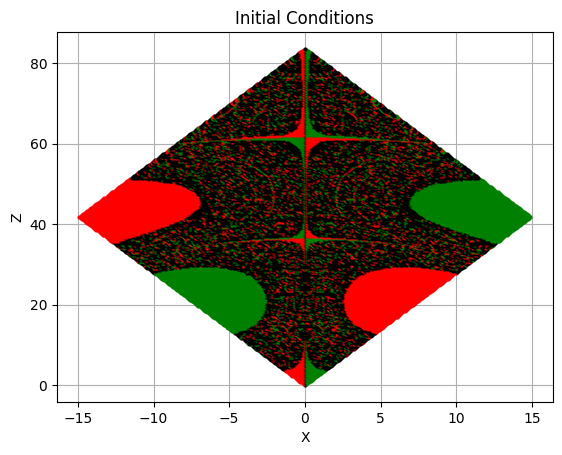

LEGEND 
 RED -- Fixed Point #1 
 GREEN -- Fixed Point #2 
 BLUE -- Butterfly

X MIN: 0, X MAX: 2, X STEP: 0.01
Z MIN: 0, Z MAX: 2, Z STEP: 0.01

Time End: 50


In [73]:
for init, classification in zip(initial_conditions, classifications):

    if classification == "Fixed Point #1": color = 'r'
    elif classification == "Fixed Point #2": color = 'g'
    else: color = 'black'

    plt.plot(init[0], init[2], marker='o', markersize=2, color=color)

plt.xlabel('X')
plt.ylabel('Z')
plt.title('Initial Conditions')
plt.grid(True)
plt.show()

print("LEGEND \n RED -- Fixed Point #1 \n GREEN -- Fixed Point #2 \n BLUE -- Butterfly")
print()
print(f"X MIN: {first_min}, X MAX: {first_max}, X STEP: {first_step}")
print(f"Z MIN: {second_min}, Z MAX: {second_max}, Z STEP: {second_step}")
print()
print(f"Time End: {t_end}")

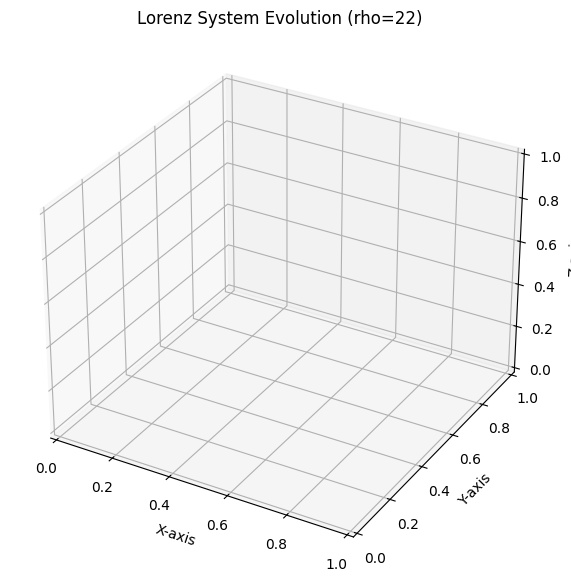

In [ ]:
# Plot results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

for traj, classification in zip(trajectories, classifications):
    color = 'r' if classification == "Fixed Point" else 'b'
    ax.plot(traj[0], traj[1], traj[2], alpha=0.7, color=color)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title(f"Lorenz System Evolution (rho={rho})")

plt.show()


# Rest

In [ ]:
%pip install reservoirpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from reservoirpy.datasets import lorenz

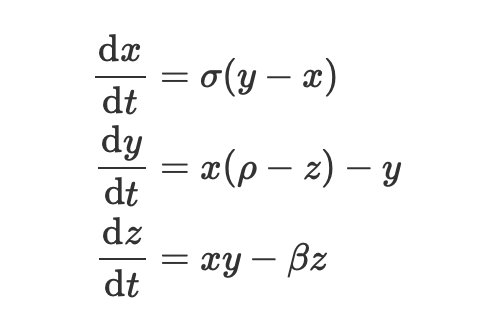

x = y = +- sqrt(b(rho - 1))

z = rho - 1

0,0,0

In [ ]:
##### DATASET #####

def dataset(n_timesteps, sigma, rho, beta, h, x0):
    data = lorenz(n_timesteps=n_timesteps, sigma=sigma, rho=rho, beta=beta, h=h, x0=x0)

    return data

def plotLorenz(data, verbose=True):
    fig = plt.figure()
    x,y,z = data.T
    ax = plt.figure().add_subplot(projection='3d')

    ax.plot(x,y,z, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")

    if verbose:
      ax_x = fig.add_subplot(3, 1, 1)
      ax_y = fig.add_subplot(3, 1, 2)
      ax_z = fig.add_subplot(3, 1, 3)

      ax_x.plot(x, lw=0.5)
      ax_x.set_xlabel("t")
      ax_x.set_ylabel("x")

      ax_y.plot(y, lw=0.5)
      ax_y.set_xlabel("t")
      ax_y.set_ylabel("y")

      ax_z.plot(z, lw=0.5)
      ax_z.set_xlabel("t")
      ax_z.set_ylabel("z")

    plt.show()

In [ ]:
n_timesteps = 50000

sigma = 10
rho = 22
beta = 8/3
h = 0.01

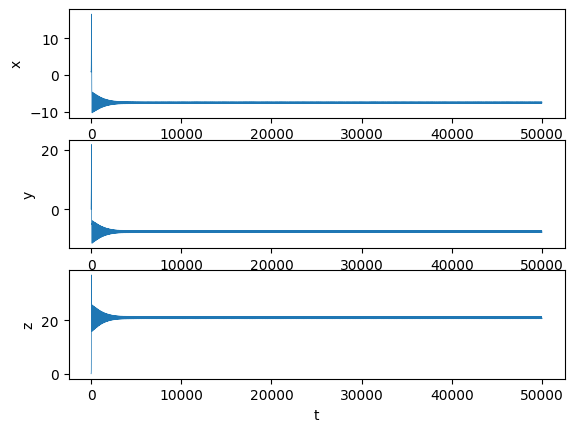

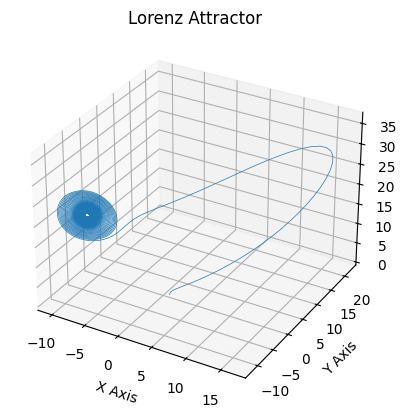

In [ ]:
x0 = [1,0,0]

data = dataset(n_timesteps, sigma, rho, beta, h, x0)
plotLorenz(data)

beta=2.6666666666666665


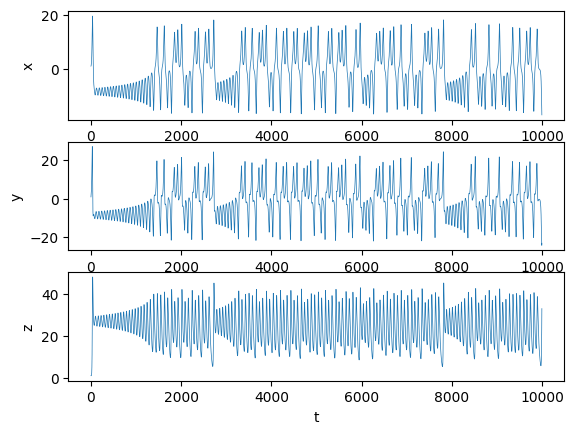

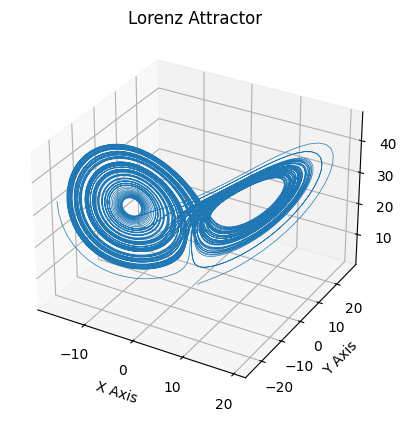

beta=2


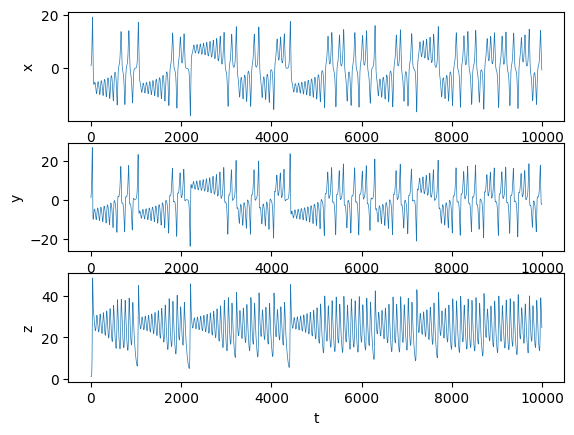

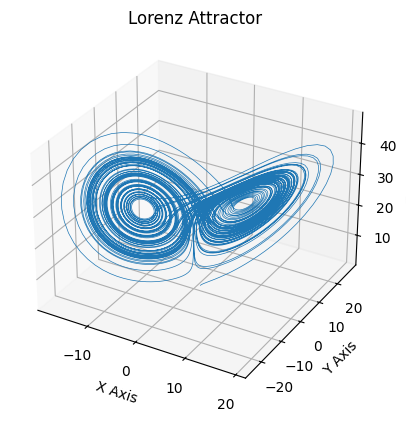

beta=4


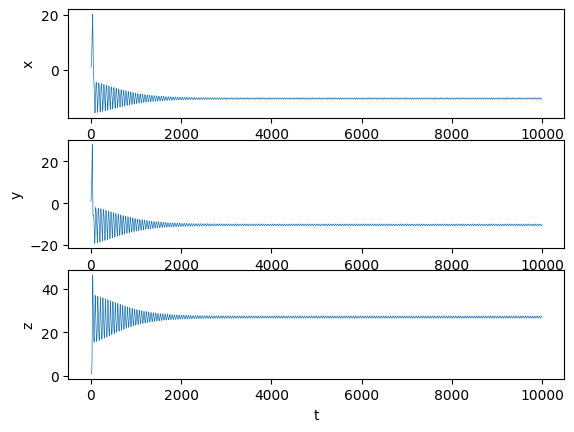

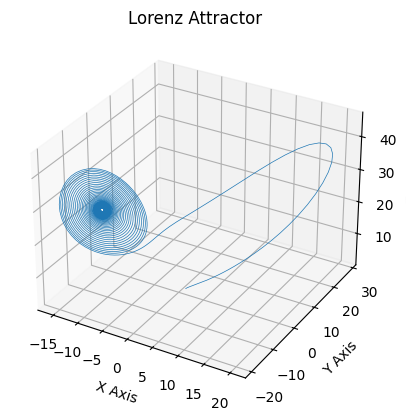

In [ ]:
n_timesteps = 10000
sigma = 10
rho = 28
beta = 8/3
h = 0.01
x0 = [1.,1.,1.]

print(f"beta={beta}")
data = dataset(n_timesteps, sigma, rho, beta, h, x0)
plotLorenz(data)

beta = 2

print(f"beta={beta}")
data = dataset(n_timesteps, sigma, rho, beta, h, x0)
plotLorenz(data)

beta = 4

print(f"beta={beta}")
data = dataset(n_timesteps, sigma, rho, beta, h, x0)
plotLorenz(data)

In [ ]:
import math

x0=(0, 0, 0)


<Figure size 640x480 with 0 Axes>

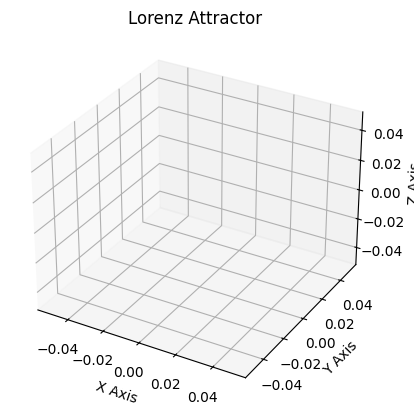

x0=(8.48528137423857, 8.48528137423857, 27)


<Figure size 640x480 with 0 Axes>

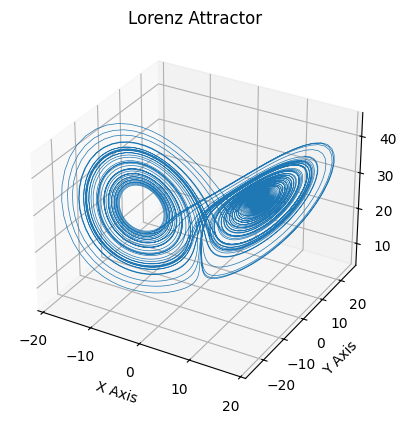

x0=(-8.48528137423857, -8.48528137423857, 27)


<Figure size 640x480 with 0 Axes>

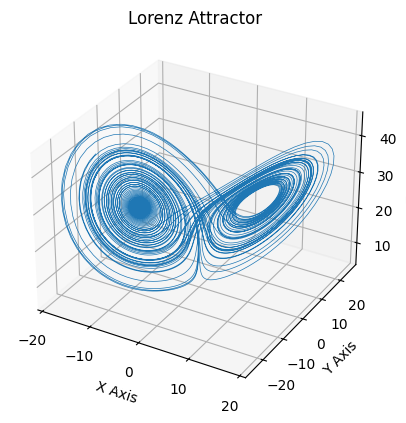

x0=[1e-08, 1e-08, 1e-08]


<Figure size 640x480 with 0 Axes>

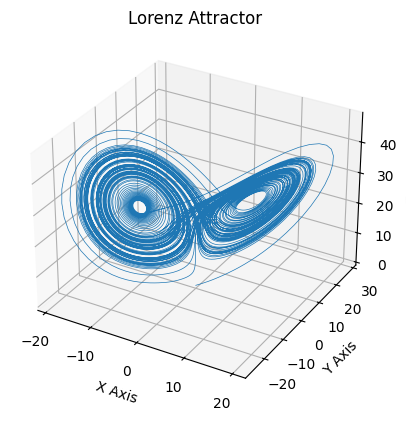

x0=[8.48528138423857, 8.48528138423857, 27.00000001]


<Figure size 640x480 with 0 Axes>

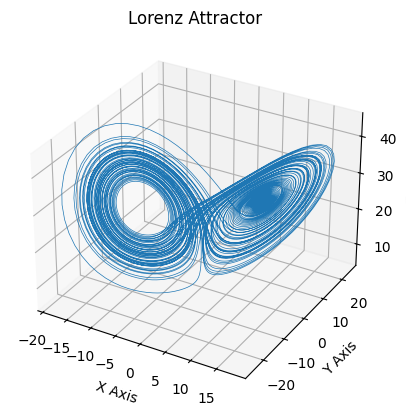

x0=[-8.485281364238569, -8.485281364238569, 27.00000001]


<Figure size 640x480 with 0 Axes>

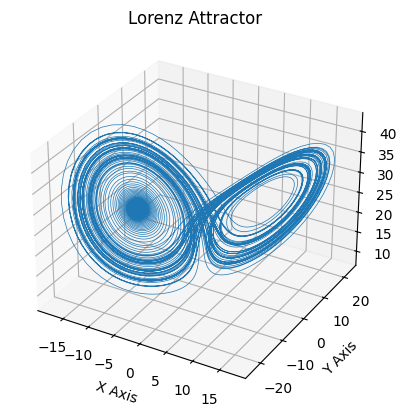

In [ ]:
fixed_points = [(0,0,0), (math.sqrt(beta*(rho-1)), math.sqrt(beta*(rho-1)), rho-1), (-math.sqrt(beta*(rho-1)), -math.sqrt(beta*(rho-1)), rho-1)]
n_timesteps = 10000
sigma = 10
rho = 28
beta = 8/3
h = 0.01

dx, dy, dz = 1e-8, 1e-8, 1e-8

for x0 in fixed_points:
    print(f"x0={x0}")
    data = dataset(n_timesteps, sigma, rho, beta, h, x0)
    plotLorenz(data, verbose=False)

for w0 in fixed_points:
    x0 = [w0[0]+dx, w0[1]+dy, w0[2]+dz]
    print(f"x0={x0}")
    data = dataset(n_timesteps, sigma, rho, beta, h, x0)
    plotLorenz(data, verbose=False)



[1e-08, 1e-08, 1e-08]


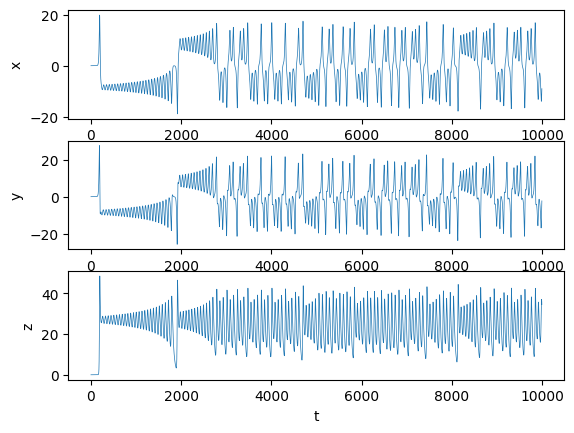

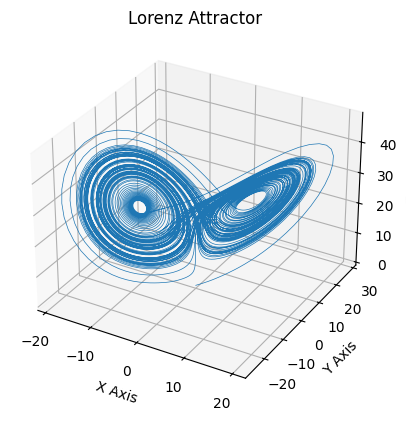

In [ ]:
n_timesteps = 10000
sigma = 10
rho = 28
beta = 8/3
h = 0.01

x0, y0, z0 = 0, 0, 0
dx, dy, dz = 1e-8, 1e-8, 1e-8
w0 = [x0+dx,y0+dy,z0+dz]
print(w0)

data = dataset(n_timesteps, sigma, rho, beta, h, w0)
plotLorenz(data)

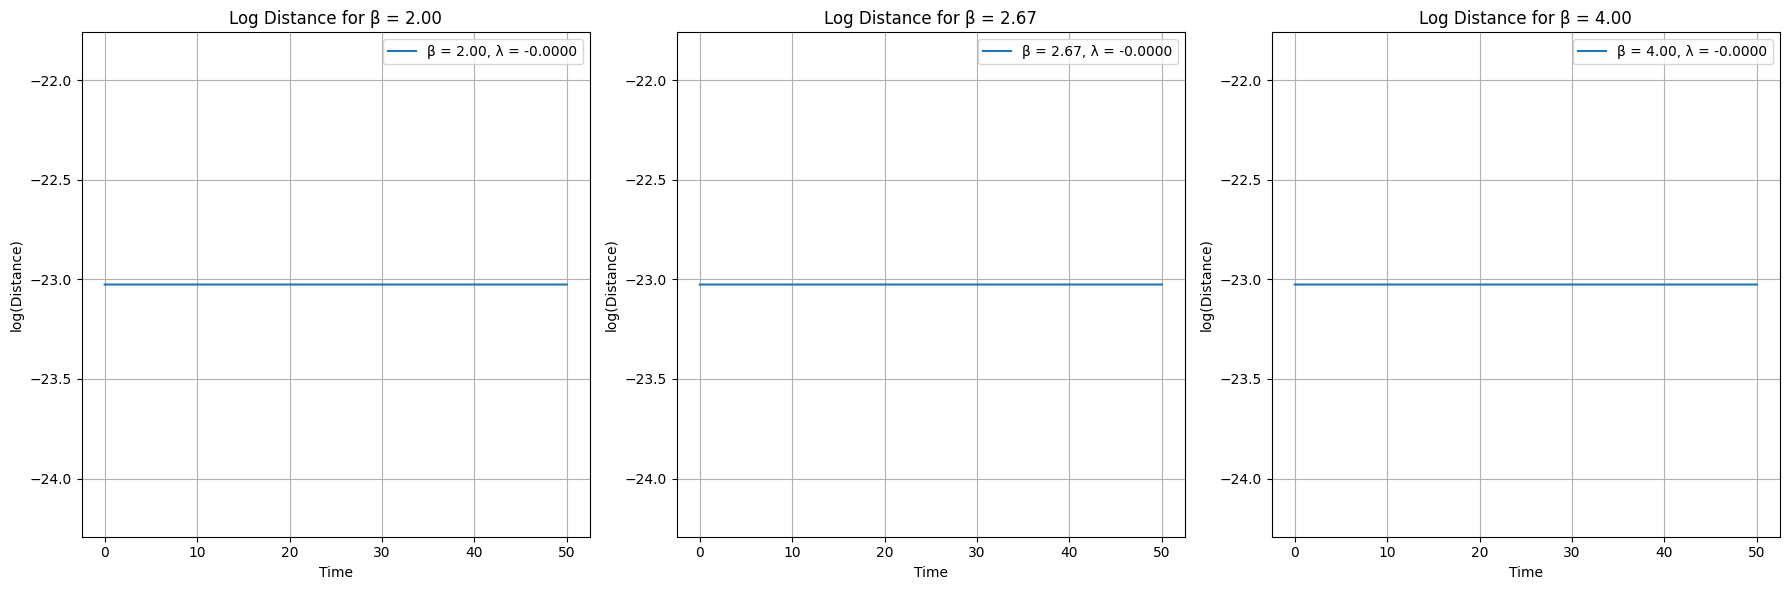

Lyapunov Exponents:
β = 2.00: λ = -0.0000
β = 2.67: λ = -0.0000
β = 4.00: λ = -0.0000


In [ ]:
from scipy.integrate import solve_ivp

# Define the Lorenz system
def lorenzsystem(t, state, sigma, beta, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Function to compute the Lyapunov exponent
def compute_lyapunov(beta, sigma, rho, initial_state, delta=1e-8, t_span=(0, 50), t_eval=np.linspace(0, 50, 10000)):
    # Slightly perturbed initial condition
    perturbed_state = [initial_state[0] + delta, initial_state[1], initial_state[2]]

    # Solve the Lorenz equations for both trajectories
    sol_original = solve_ivp(lorenzsystem, t_span, initial_state, args=(sigma, beta, rho), t_eval=t_eval)
    sol_perturbed = solve_ivp(lorenzsystem, t_span, perturbed_state, args=(sigma, beta, rho), t_eval=t_eval)

    # Extract solutions
    traj_original = sol_original.y.T
    traj_perturbed = sol_perturbed.y.T

    # Compute the distance between the trajectories at each time step
    distances = np.linalg.norm(traj_original - traj_perturbed, axis=1)

    # Avoid log of zero by setting a minimum distance threshold
    distances = np.maximum(distances, 1e-10)

    # Compute the logarithm of distances
    log_distances = np.log(distances)

    # Fit a linear model to the logarithm of distances to estimate the Lyapunov exponent
    time = sol_original.t
    slope, _ = np.polyfit(time, log_distances, 1)  # Linear fit

    return log_distances, slope, time

# Parameters
sigma = 10
rho = 28
beta_values = [2, 8/3, 4]  # Low, typical, and high beta values
initial_state = [1.0, 1.0, 1.0]  # Initial conditions
t_span = (0, 50)  # Time range
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Time points

# Visualization of trajectory divergence for each beta
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, beta in zip(axes, beta_values):
    # Compute the Lyapunov exponent and log distances
    log_distances, slope, time = compute_lyapunov(beta, sigma, rho, initial_state)

    # Plot the logarithm of distances over time
    ax.plot(time, log_distances, label=f"β = {beta:.2f}, λ = {slope:.4f}")
    ax.set_title(f"Log Distance for β = {beta:.2f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("log(Distance)")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

# Print Lyapunov exponents for each beta
print("Lyapunov Exponents:")
for beta in beta_values:
    _, slope, _ = compute_lyapunov(beta, sigma, rho, initial_state)
    print(f"β = {beta:.2f}: λ = {slope:.4f}")

wrong lyapunov exp... should be slightly less than 1 for beta=8/3


read discussion on lyapunov exponent, first 3 chapters